In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from math import exp, log
from tqdm.notebook import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Read data

data1 = pd.read_csv("chips.csv")
data2 = pd.read_csv("geyser.csv")

In [4]:
# Convert to arrays

def convert_classes(c):
    ans = []
    for i in c:
        if i == 'N':
            ans.append(-1)
        else:
            ans.append(1)
    return ans
    
classes = []
attributes = []

classes.append(convert_classes(data1["class"].values))
attributes.append(data1.drop("class", axis=1).values)

classes.append(convert_classes(data2["class"].values))
attributes.append(data2.drop("class", axis=1).values)

In [5]:
class AdaBoost():
    def __init__(self, n):
        self.T = []
        self.B_T = []
        self.n = n
        self.W = [1.0 / n for i in range(n)]
    
    def do_iter(self, X, Y):
        t = DecisionTreeClassifier(max_depth=4, splitter="random")
        t.fit(X, Y, sample_weight=self.W)
        self.T.append(t)
        Y_P = t.predict(X)
        
        eps = 0.000001
        N_t = sum([self.W[i] * int(Y[i] * Y_P[i] < 0) for i in range(self.n)]) + eps
        b_t = log((1 - N_t) / N_t) / 2
        self.B_T.append(b_t)
        
        self.W = [self.W[i] * exp(-b_t * Y[i] * Y_P[i]) for i in range(self.n)]
        s = sum(self.W)
        self.W = [w / s for w in self.W]
    
    def predict_one(self, x):
        y = 0.0
        for (t, b_t) in zip(self.T, self.B_T):
            y += t.predict([x]) * b_t
        return np.sign(y)
    
    def predict(self, X):
        return [self.predict_one(x) for x in X]
    
    def score(self, X, Y):
        return accuracy_score(self.predict(X), Y)

In [6]:
# From SVM

def draw(a, c, model, step, ind):
    x_max, y_max = np.amax(a, 0)
    x_min, y_min = np.amin(a, 0)
    
    X, Y = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, 0.01))
    AX   = np.apply_along_axis(lambda s: model.predict_one(s), 1, np.c_[X.ravel(), Y.ravel()])

    x_0, x_1 = np.array([]), np.array([])
    y_0, y_1 = np.array([]), np.array([])
    for i in range(len(a)):
        if c[i] == -1:
            x_0, y_0 = np.append(x_0, a[i][0]), np.append(y_0, a[i][1])
        else:
            x_1, y_1 = np.append(x_1, a[i][0]), np.append(y_1, a[i][1])
    
    plt.subplot(ind)
    plt.xlim(x_min, x_max), plt.ylim(y_min, y_max)
    plt.pcolormesh(X, Y, np.array(AX).reshape(X.shape),
                   cmap=ListedColormap(['#799FE1', '#FC9797']), shading="auto")
    plt.scatter(x_0, y_0, color='blue', s=20)
    plt.scatter(x_1, y_1, color='red',  s=20)

In [9]:
def draw_plot(iters, accs):
    plt.figure(figsize=(16, 12))
    plt.xlabel("Iters")
    plt.ylabel("Accuracy")
    plt.plot(iters, accs)
    plt.show()

def results_with_draw_grid(X, Y, model):
    iters = []
    accs = []
    
    draw_steps = [1, 2, 3, 5, 8, 13, 21, 34, 55]
    plt.figure(figsize=(18, 18))
    
    j = 331 # 3 x 3
    for i in tqdm(range(1, 56)):
        model.do_iter(X, Y)
        iters.append(i)
        accs.append(model.score(X, Y))
        if i in draw_steps:
            draw(X, Y, model, 0.01, j)
            plt.title("Iter " + str(i))
            j += 1
    
    plt.show()
    return (iters, accs)

def ada_boost(X, Y):
    (iters, accs) = results_with_draw_grid(X, Y, AdaBoost(len(X)))
    draw_plot(iters, accs)

# Chips

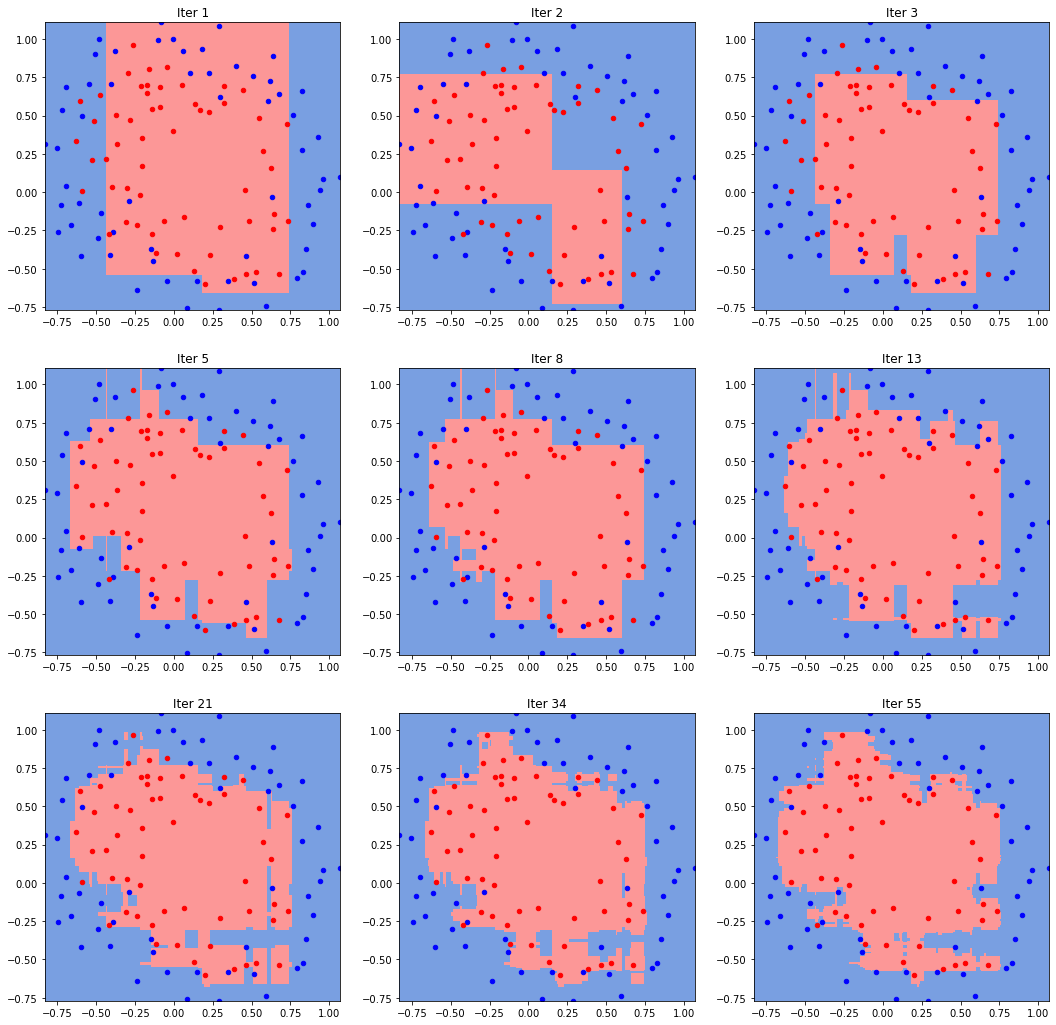

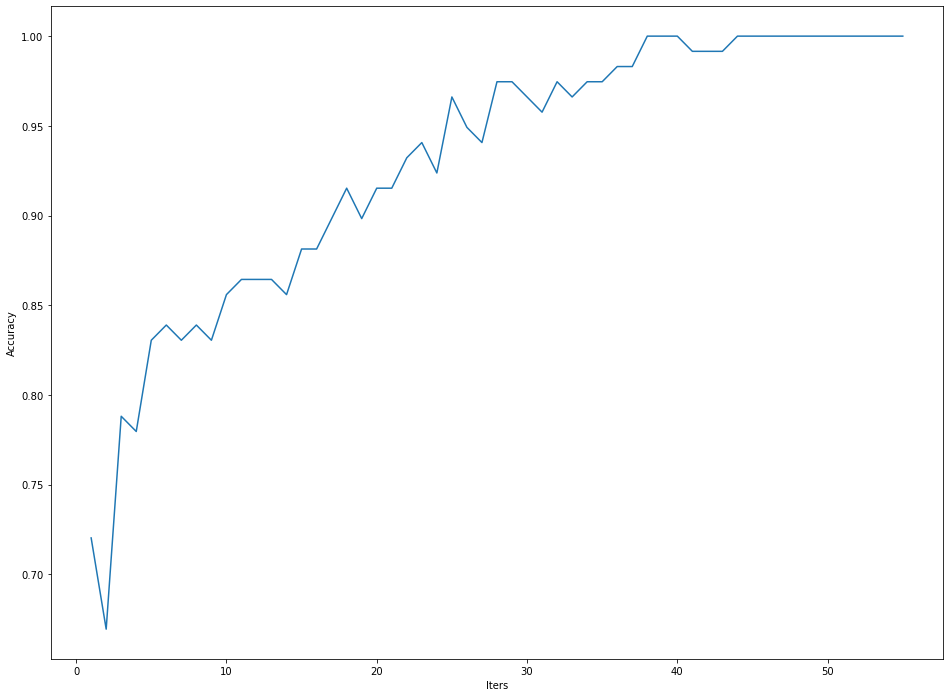

In [7]:
ada_boost(attributes[0], classes[0])

# Geyser

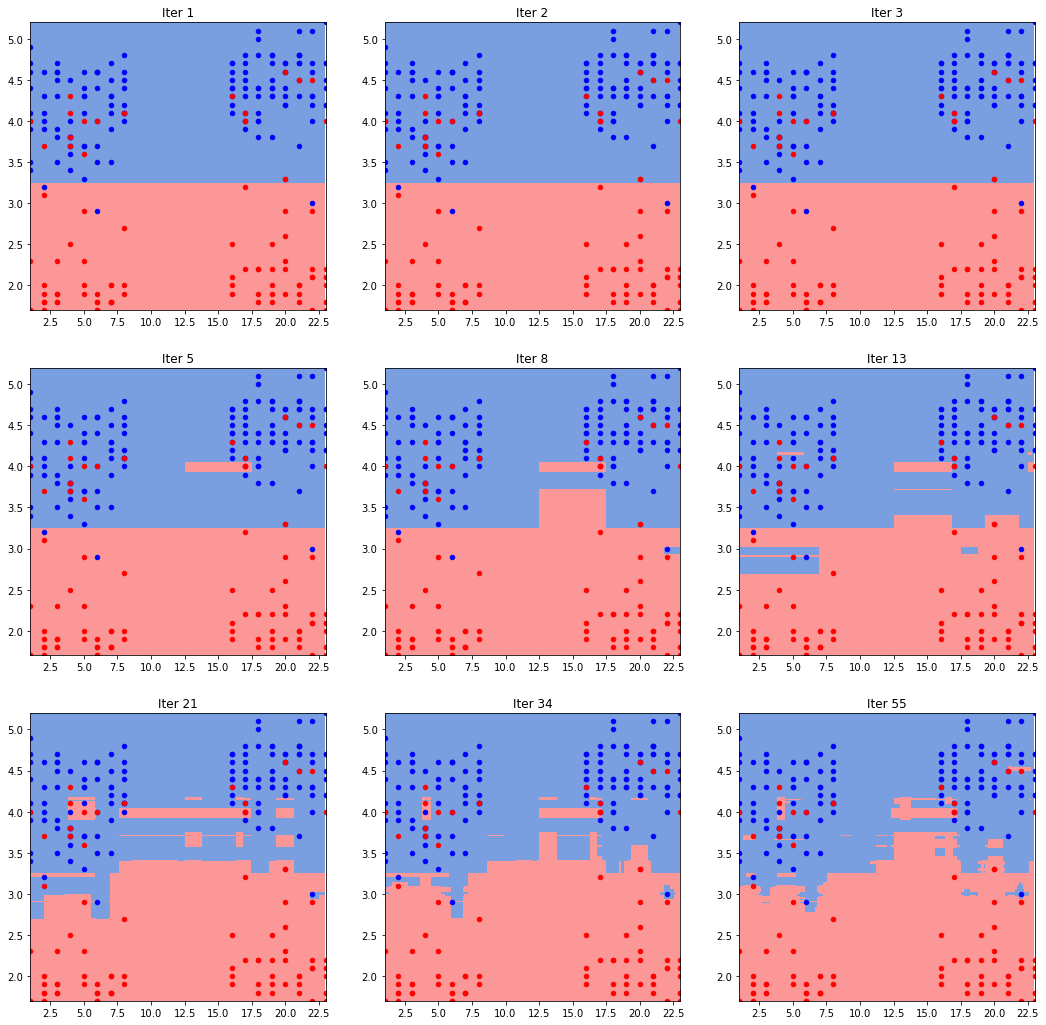

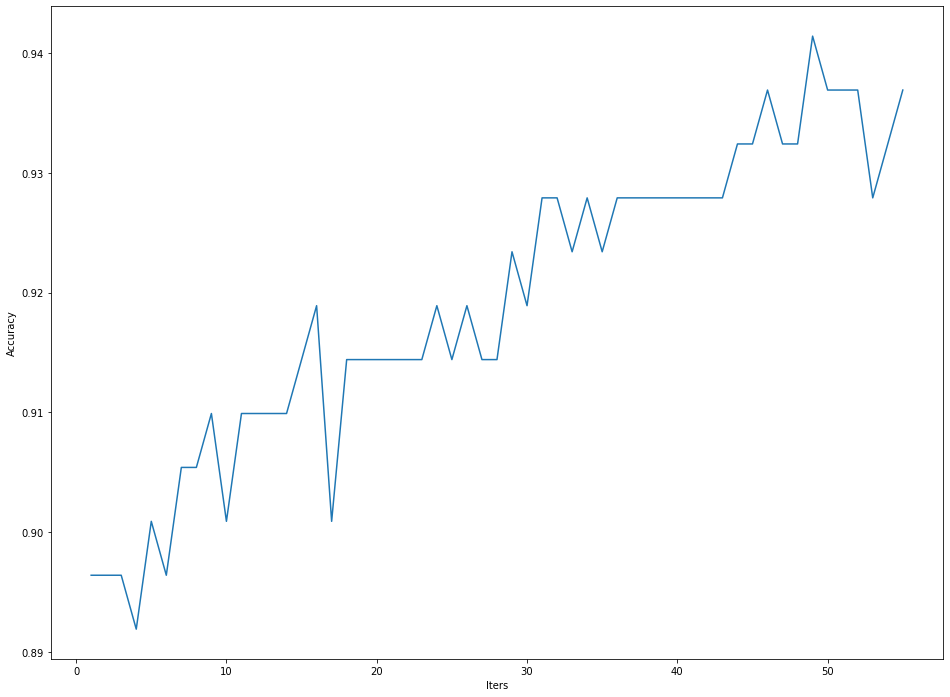

In [10]:
ada_boost(attributes[1], classes[1])